<a href="https://colab.research.google.com/github/taasinsaquib/retina/blob/main/nengo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/thesis_stuff/'

/content/drive/MyDrive/thesis_stuff


In [3]:
# ! pip install livelossplot torchinfo --quiet
! pip install nengo nengo_dl tensorflow-gpu --quiet

     |████████████████████████████████| 523 kB 4.3 MB/s 
     |████████████████████████████████| 283 kB 55.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 458.3 MB 10 kB/s 


In [4]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import nengo
import nengo_dl
from nengo.utils.matplotlib import rasterplot

import warnings
import datetime, os

warnings.simplefilter("ignore")
tf.get_logger().addFilter(lambda rec: "Tracing is expensive" not in rec.msg)

In [5]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# choose first GPU if available
physicalDevices = tf.config.list_physical_devices('GPU')
device = "/gpu:0" if len(physicalDevices) > 0 else "/cpu:0"

print(physicalDevices)
print(device)

# device = '/gpu:0'

[]
/cpu:0


In [6]:
seed = 28

np.random.seed(seed)

# ONV has 14400 photoreceptors, reshape to a square for RESNET
nPhotoreceptors = 14400
w = 120
h = 120

batchSize = 32

nSteps = 10

# Data (add time)

In [66]:
data_train = np.load('./center/data_train.npy')
data_test  = np.load('./center/data_test.npy')

labels_train = np.load('./center/labels_train.npy') * 180/np.pi
labels_test  = np.load('./center/labels_test.npy')  * 180/np.pi

In [ ]:
data_train = np.load('./center/data_train.npy')[:32]
data_test  = np.load('./center/data_test.npy')[:32]

labels_train = np.load('./center/labels_train.npy')[:32] * 180/np.pi
labels_test  = np.load('./center/labels_test.npy')[:32]  * 180/np.pi

In [67]:
data_train = data_train[:, None, :]
labels_train = labels_train[:, None, :]
print(data_train.shape, labels_train.shape)

(1676, 1, 14400) (1676, 1, 3)


In [68]:
data_test = data_test[:, None, :]
labels_test = labels_test[:, None, :]
print(data_test.shape, labels_test.shape)

(409, 1, 14400) (409, 1, 3)


In [53]:
# TODO: create data loader

In [54]:
# data_train = tf.data.Dataset.from_tensor_slices(data_train).batch(batchSize)
# labels_train = tf.data.Dataset.from_tensor_slices(labels_train).batch(batchSize)

# data_test = tf.data.Dataset.from_tensor_slices(data_test).batch(batchSize)
# labels_test = tf.data.Dataset.from_tensor_slices(labels_test).batch(batchSize)

In [59]:
dataset = tf.data.Dataset.from_tensor_slices((data_train, labels_train))

In [23]:
# data_train = np.tile(data_train, (1, nSteps, 1))
# labels_train = np.tile(labels_train, (1, n_Steps, 1))

# data_test = np.tile(data_test, (1, nSteps, 1))
# labels_test = np.tile(labels_test, (1, nSteps, 1))

# Network

In [ ]:
# TODO: see what loss I can get with normal tf ANN
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1000, activation=tf.nn.relu, input_shape=(14400,)),  # input shape required
  tf.keras.layers.Dense(100, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [112]:
with nengo.Network(seed=seed) as net:
  # neuron_type = nengo.LIFRate(amplitude=0.01)
  neuron_type = nengo.RectifiedLinear()

  input = nengo.Node(np.zeros(nPhotoreceptors))

  x = nengo_dl.Layer(tf.keras.layers.Dense(units=1000))(input)
  x = nengo_dl.Layer(neuron_type)(x)

  x = nengo_dl.Layer(tf.keras.layers.Dense(units=100))(x)
  x = nengo_dl.Layer(neuron_type)(x)

  # x = nengo_dl.Layer(tf.keras.layers.AveragePooling1D(1))(x, shape_out=100)

  out = nengo_dl.Layer(tf.keras.layers.Dense(units=3))(x)

  # we'll create two different output probes, one with a filter
  # (for when we're simulating the network over time and
  # accumulating spikes), and one without (for when we're
  # training the network using a rate-based approximation)
  out_p = nengo.Probe(out)
  # out_p_filt = nengo.Probe(x, synapse=0.1)

In [64]:
with nengo.Network(seed=seed) as net:
  # nengo_dl.configure_settings(lif_smoothing=x)
  # nengo_dl.configure_settings(inference_only=True)  # for testing

  neuron_type = nengo.LIFRate(amplitude=0.01)

  inp = nengo.Node(np.zeros(nPhotoreceptors), label='input')     # TODO: set output to test Poisson encoding
  # inp = nengo.Node([0])
  inp_p = nengo.Probe(inp)


  # reduce dimensionality with ANN and RELU (TODO: can experiment with spiking activation later)
  x = nengo_dl.Layer(tf.keras.layers.Dense(units=10000))(inp)
  x = nengo_dl.Layer(nengo.RectifiedLinear())(x)

  x = nengo_dl.Layer(tf.keras.layers.Dense(units=1000))(x)
  x = nengo_dl.Layer(nengo.RectifiedLinear())(x)

  x = nengo_dl.Layer(tf.keras.layers.Dense(units=100))(x)
  x = nengo_dl.Layer(nengo.RectifiedLinear())(x)

  # SNN part
  # TODO: use PES, not sure how to get the outputs though

  pre = nengo.Ensemble(1000, dimensions=100, neuron_type=neuron_type)           # TODO: encoders and noise

  # hidden_layer = nengo.Ensemble(nPhotoreceptors, dimensions=nPhotoreceptors)  # TODO: make network deeper

  post = nengo.Ensemble(100, dimensions=10, neuron_type=neuron_type)            # TODO: set intercepts
  weights = np.zeros((10, 100))
  conn = nengo.Connection(pre, post, transform=weights, learning_rule_type=nengo.PES())
  
  out = nengo_dl.Layer(tf.keras.layers.Dense(units=3))(post)
  
  # out = x

  out_p = nengo.Probe(out)


  # out = nengo.Node(size_in=nPhotoreceptors, size_out=3)



In [12]:
with nengo.Network(seed=seed) as net:
  neuron_type = nengo.LIFRate(amplitude=0.01)

  inp = nengo.Node(np.zeros(nPhotoreceptors), label='input')
  inp_p = nengo.Probe(inp)

  # add the Dense layers, as in the Keras model
  hidden = nengo_dl.Layer(tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(
      inp
  )
  out = nengo_dl.Layer(tf.keras.layers.Dense(units=3))(hidden)

  # add a probe to collect output
  out_p = nengo.Probe(out)

# Train

In [14]:
data_train = np.zeros((32, 1, 14400))
labels_train = np.ones((32, 1, 3))

In [15]:
# data_train=np.random.random((32, 1, 14400)) # TODO: probe inputs to see wtf is being passed as input
with nengo_dl.Simulator(net, seed=seed, device=device, minibatch_size=batchSize) as sim:

  # Train
  sim.compile(
      optimizer=tf.optimizers.Adam(),
      loss={out_p: tf.losses.MSE},
      metrics=["accuracy"],
  )
  
  x = {
      inp: data_train,
      # 'n_steps': data_train * 10
  }
  # sim.fit(data_train, {out_p: labels_train}, epochs=2)
  # sim.fit(x=data_train, epochs=2)
  sim.fit(data_train, labels_train, epochs=2)

  # sim.save_params("./my_saved_params")
  # sim2.load_params("./my_saved_params")
  # sim.freeze_params(net)                # prevent further training

  # Test
  data = sim.predict(data_test[:batchSize])
  # print(data[:4], labels_test[:4]) # unhashable type: 'slice'

  print(dir(sim.data))
  print(sim.data[inp_p])
  print(sim.data[out_p])

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/2


ValueError: ignored

In [97]:
print(sim.data[inp_p])

[]


In [11]:
with nengo.Network(seed=seed) as net:
  neuron_type = nengo.LIFRate(amplitude=0.01)

  inp = nengo.Node(np.ones(10), label='input')
  inp_p = nengo.Probe(inp)

  # x = nengo_dl.Layer(tf.keras.layers.Dense(units=1))(inp)
  # x = nengo_dl.Layer(nengo.RectifiedLinear())(x)

  pre = nengo.Ensemble(10, dimensions=10, neuron_type=neuron_type)

  c = nengo.Connection(inp, pre)

  post = nengo.Ensemble(10, dimensions=3, neuron_type=neuron_type)
  weights = np.zeros((3, 10))
  conn = nengo.Connection(pre, post, transform=weights, learning_rule_type=nengo.PES())

  # c = nengo.Connection(inp, pre, transform=weights)

  # out = nengo_dl.Layer(tf.keras.layers.Dense(units=3))(inp)
  out_p = nengo.Probe(post)


with nengo_dl.Simulator(net, minibatch_size=batchSize) as sim:
  sim.compile(
    # loss="mse",
    loss = {out_p: tf.losses.MSE},
    optimizer = tf.optimizers.Adam(1e-2)
  )

  d = np.ones((32, 1, 10))
  l = np.random.random((32, 1, 3))

  sim.fit(x={inp:d}, y=l, epochs=1)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


ValueError: ignored

# Error Example

In [4]:
import nengo
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

In [5]:
model = nengo.Network()
with model:
    inp = nengo.Node(WhiteSignal(60, high=5), size_out=2)
    pre = nengo.Ensemble(60, dimensions=2)
    nengo.Connection(inp, pre)
    post = nengo.Ensemble(60, dimensions=2)
    conn = nengo.Connection(pre, post, function=lambda x: np.random.random(2))
    inp_p = nengo.Probe(inp)
    pre_p = nengo.Probe(pre, synapse=0.01)
    post_p = nengo.Probe(post, synapse=0.01)

In [6]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

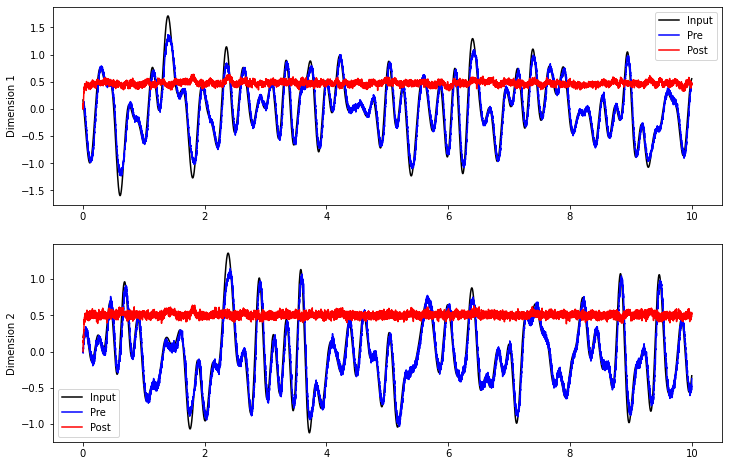

In [7]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[0], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_p].T[0], c="r", label="Post")
plt.ylabel("Dimension 1")
plt.legend(loc="best")
plt.subplot(2, 1, 2)
plt.plot(sim.trange(), sim.data[inp_p].T[1], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[1], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_p].T[1], c="r", label="Post")
plt.ylabel("Dimension 2")
plt.legend(loc="best")

In [8]:
with model:
    error = nengo.Ensemble(60, dimensions=2)
    error_p = nengo.Probe(error, synapse=0.03)

    # Error = actual - target = post - pre
    nengo.Connection(post, error)
    nengo.Connection(pre, error, transform=-1)

    # Add the learning rule to the connection
    conn.learning_rule_type = nengo.PES()

    # Connect the error into the learning rule
    nengo.Connection(error, conn.learning_rule)

In [9]:
with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

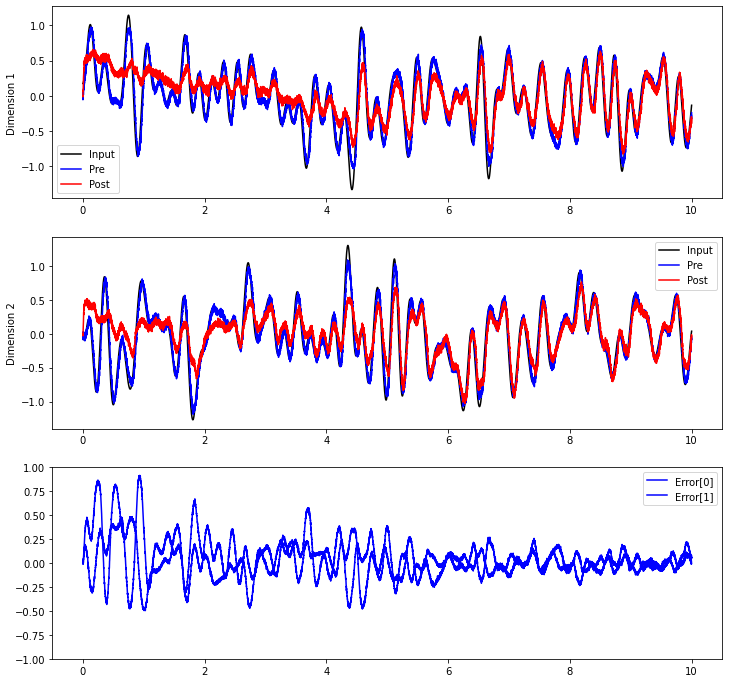

In [10]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(sim.trange(), sim.data[inp_p].T[0], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[0], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_p].T[0], c="r", label="Post")
plt.ylabel("Dimension 1")
plt.legend(loc="best")
plt.subplot(3, 1, 2)
plt.plot(sim.trange(), sim.data[inp_p].T[1], c="k", label="Input")
plt.plot(sim.trange(), sim.data[pre_p].T[1], c="b", label="Pre")
plt.plot(sim.trange(), sim.data[post_p].T[1], c="r", label="Post")
plt.ylabel("Dimension 2")
plt.legend(loc="best")
plt.subplot(3, 1, 3)
plt.plot(sim.trange(), sim.data[error_p], c="b")
plt.ylim(-1, 1)
plt.legend(("Error[0]", "Error[1]"), loc="best")

#Try

In [135]:
with nengo.Network() as net:
    # our input node will output a sine wave with a period of 1 second
    a = nengo.Node(lambda t: np.sin(2 * np.pi * t))
    # a = nengo.Node(0)

    # we'll create one ensemble with rate neurons
    b_rate = nengo.Ensemble(10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_rate)

    # and another ensemble with spiking neurons
    b_spike = nengo.Ensemble(10, 1, neuron_type=nengo.RectifiedLinear(), seed=2)
    nengo.Connection(a, b_spike)

    p_a = nengo.Probe(a)
    p_rate = nengo.Probe(b_rate.neurons)
    p_spike = nengo.Probe(b_spike.neurons)

with nengo_dl.Simulator(net) as sim:
    # simulate the model for 1 second
    # note that we are not providing any input data, so input
    # data will be automatically generated based on the sine function
    # in the Node definition.
    # sim.run_steps(1000, data=np.ones((1, 1000, 1)))
    
    sim.compile(
        optimizer=tf.optimizers.Adam(),
        loss={out_p: tf.losses.MSE},
    )
    sim.fit(x=np.ones((1, 1000, 1)))

print(sim.data[p_a].shape)

plt.figure()
plt.plot(sim.trange(), sim.data[p_a])
plt.xlabel("time")
plt.ylabel("input value")
plt.title("a")

plt.figure()
plt.plot(sim.trange(), sim.data[p_rate])
plt.xlabel("time")
plt.ylabel("firing rate")
plt.title("b_rate")

plt.figure()
rasterplot(sim.trange(), sim.data[p_spike])
plt.xlabel("time")
plt.ylabel("neuron")
plt.title("b_spike")
plt.show()

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               


ValidationError: ignored

# IT WORKS!
* [Worked from this tutorial](https://www.nengo.ai/nengo-dl/examples/tensorflow-models.html)

In [20]:
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.fashion_mnist.load_data()

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

4431872/4422102 [==============================] - 0s 0us/step


In [21]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [22]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [23]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 1, 784) (60000, 1, 1)
(10000, 1, 784) (10000, 1, 1)


In [69]:
# num_classes = 10
minibatch_size = 32

# train_images = np.zeros((32, 1, 14400))
# train_labels = np.ones((32, 1, 3))

# test_images = np.zeros((32, 1, 14400))
# test_labels = np.ones((32, 1, 3))

with nengo.Network(seed=seed) as net:
    neuron_type = nengo.LIF(amplitude=0.01)
    
    # input node, same as before
    # inp = nengo.Node(output=np.ones(28 * 28))
    # inp = nengo.Node(np.ones(28 * 28))
    inp = nengo.Node(output=np.ones(14400))

    # add the Dense layers, as in the Keras model
    # """
    x = nengo_dl.Layer(tf.keras.layers.Dense(units=10000, activation=tf.nn.relu))(inp)
    # x = nengo_dl.Layer(nengo.RectifiedLinear())(x)

    x = nengo_dl.Layer(tf.keras.layers.Dense(units=1000, activation=tf.nn.relu))(x)
    # x = nengo_dl.Layer(nengo.RectifiedLinear())(x)

    x = nengo_dl.Layer(tf.keras.layers.Dense(units=100, activation=tf.nn.relu))(x)
    # x = nengo_dl.Layer(nengo.RectifiedLinear())(x)
    # """

    # no gradient warning if you try to replace dense with ensemble
    # x = nengo.Ensemble(10, 1, neuron_type=nengo.RectifiedLinear()).neurons
    # weights = np.zeros((10, 14400))
    # nengo.Connection(inp, x, transform=weights)

    # """
    pre = nengo.Ensemble(100, dimensions=100, neuron_type=neuron_type) 
    c = nengo.Connection(x, pre)
    # p = nengo_dl.TensorNode(x)

    post = nengo.Ensemble(100, dimensions=10, neuron_type=neuron_type)
    weights = np.zeros((10, 100))
    conn = nengo.Connection(pre, post, transform=weights, learning_rule_type=nengo.PES())
    # """

    out = nengo_dl.Layer(tf.keras.layers.Dense(units=3))(x)
    out_p = nengo.Probe(out)    # add a probe to collect output

# causes no gradients warning
# with net:
    # nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(
        optimizer=tf.optimizers.Adam(1e-1),
        # loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        loss=tf.losses.MSE,
        metrics=["accuracy"],
    )
    sim.fit(data_train, labels_train, epochs=10)

    print(
        "Test accuracy:",
        sim.evaluate(data_test, labels_test, verbose=0)["probe_accuracy"],
    )

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:01                                               
Epoch 1/10
52/52 [==============================] - 83s 2s/step - loss: 15807555829760.0000 - probe_loss: 15807555829760.0000 - probe_accuracy: 0.3245
Epoch 2/10
52/52 [==============================] - 79s 2s/step - loss: 68537520.0000 - probe_loss: 68537520.0000 - probe_accuracy: 0.3329
Epoch 3/10
52/52 [==============================] - 81s 2s/step - loss: 10724015.0000 - probe_loss: 10724015.0000 - probe_accuracy: 0.3095
Epoch 4/10
52/52 [==============================] - 79s 2s/step - loss: 3398749.0000 - probe_loss: 3398749.0000 - probe_accuracy: 0.3167
Epoch 5/10
52/52 [==============================] - 82s 2s/step - loss: 3263093.0000 - probe_loss: 3263093.0000 - probe_accuracy: 0.3215
Epoch 6/10
52/52 [==============================] - 78s 1